<a href="https://colab.research.google.com/github/dalitina/Hello_World/blob/master/Mask_sensitive_data_FODIS_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
! apt install tesseract-ocr
! apt install libtesseract-dev
! apt-get install tesseract-ocr-deu #for deutsch (German)
! apt-get install poppler-utils
! pip install pytesseract
! pip install opencv-python-headless pytesseract pillow spacy  pypdf2 PIL
! pip install stanza
! pip install matplotlib

!pip install pdf2image
!pip install python-bidi==0.4.2
!pip install easyocr torch torchvision

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-deu is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
  Using cached pypdf2-3.0.1-py3-none-any.whl (232 kB)
ERROR: Could not find a version

In [37]:
import stanza
stanza.download('de')

nlp = stanza.Pipeline(lang='de', processors='tokenize,pos,ner')


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: de (German) ...
INFO:stanza:File exists: /root/stanza_resources/de/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: de (German):
| Processor | Package      |
----------------------------
| tokenize  | gsd          |
| mwt       | gsd          |
| pos       | gsd_charlm   |
| ner       | germeval2014 |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [38]:
import os
import pdf2image
import pytesseract
import easyocr
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import logging
import re
from pdf2image import convert_from_path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2
from typing import List, Tuple
import numpy as np
import pandas

In [39]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)



#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

In [40]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [41]:
def load_document(file_path: str) -> Tuple[np.ndarray, bool]:
    """Loads an image or PDF into a numpy array.

    Args:
        file_path (str): The path to the image or PDF file.

    Returns:
        Tuple[np.ndarray, bool]: A tuple containing the loaded image as a numpy array and
                                a boolean indicating if it was a PDF (True) or image (False).
    """
    is_pdf = file_path.endswith(".pdf")
    if is_pdf:
        images = convert_from_path(file_path) # Extract images from PDF
        img = np.array(images[0]) # Get the first page as an image
    else:
        img = cv2.imread(file_path)

    return img


def preprocess_image(img, adv_processing = False):
    """
    Preprocesses images to improve OCR accuracy.

    Args:
        img (str): img as numpy array.
        blur (bool): Whether to apply Gaussian blur (default: False).

    Returns:
        numpy.ndarray or None: Preprocessed image (grayscale, thresholded, optionally blurred)
                               if successful, None otherwise.
    """
    try:

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        if adv_processing:
            processed = remove_noise(thresh)
            # processed = dilate(processed)
            # processed = erode(processed)
            # processed = canny (thresh)

            return processed
        else:
            return thresh  # Return thresholded image without blurring

    except Exception as e:
        logging.error(f"Error preprocessing image {img_path}: {e}")
        return None



def extract_text(
    img,
    confidence_threshold=20,
    psm=11,
    oem=1,
    lang="deu",
    custom_config="",
):
    """
    Extracts text with confidence and bounding boxes using Tesseract, handling encoding issues.

    Args:
        img (PIL.Image.Image or numpy.ndarray): Image to extract text from.
        confidence_threshold (int): Minimum confidence level (0-100) to keep a text detection.
        psm (int): Tesseract page segmentation mode (e.g., 11 for sparse text).
        oem (int): Tesseract OCR engine mode (e.g., 1 for LSTM).
        lang (str): Language code (e.g., 'deu' for German).
        custom_config (str): Additional Tesseract configuration options as a string.

    Returns:
        list: List of tuples, each containing (word, x, y, width, height, confidence) of extracted text, with correct encoding.
    """

    try:
        config = f"--psm {psm} --oem {oem} -l {lang} {custom_config}"
        data = pytesseract.image_to_data(img, config=config, output_type=pytesseract.Output.DICT)

        # Handle characters outside the latin-1 range
        for i, word in enumerate(data["text"]):
            try:
                data["text"][i] = word.encode("utf-8").decode("utf-8")
            except UnicodeEncodeError:
                # Replace problematic characters with a suitable replacement
                data["text"][i] = word.encode("utf-8", "replace").decode("utf-8")

        filtered_data = [
            (word, left, top, width, height, conf)
            for word, left, top, width, height, conf in zip(
                data["text"],
                data["left"],
                data["top"],
                data["width"],
                data["height"],
                data["conf"],
            )
            if int(conf) > confidence_threshold and word.strip()
        ]

        return filtered_data

    except Exception as e:
        logging.error(f"Error extracting text: {e}")
        return []


def extract_person_names(text_data):
    """
    Extracts person names with their bounding boxes from the extracted text data using spaCy NER.

    Args:
        text_data (list): List of tuples, each containing (word, x, y, width, height, confidence) of extracted text.

    Returns:
        list: List of tuples representing person names with format (name, x, y, w, h, conf).
    """
    nlp = spacy.load("de_core_news_sm")
    person_names = []

    for word, x, y, w, h, conf in text_data:
        doc = nlp(word)
        for ent in doc.ents:
            if ent.label_ == "PER":  # Check if entity is a person
                person_names.append((ent.text, x, y, w, h, conf))

    return person_names

def find_entities(word_data, entity_type, probability_threshold):
    """
    Identifies entities of a given type from OCR word data using staza library.

    Args:
        word_data: List of lists, each containing [word, left, top, width, height, probability].
        entity_type: String specifying the entity type (e.g., "LOC", "PERSON").
        probability_threshold: Minimum OCR probability for words to be considered.

    Returns:
        List of tuples, each containing (entity text, bbox coordinates, avg_probability).
    """


    filtered_words = [(word, left, top, width, height, probability) for word, left, top, width, height, probability in word_data if probability >= probability_threshold]
    text = " ".join([word for word, _, _, _, _, _ in filtered_words])

    doc = nlp(text)

    entities = []

    for ent in doc.ents:
        if ent.type == entity_type:
            entity_words = [word for word in filtered_words if word[0] in ent.text.split()]

            # Calculate bounding box in left, top, width, height format
            left = min(word[1] for word in entity_words)
            # Account for baseline offset for text in images
            top = min(word[2]  for word in entity_words)  # bottom of the bounding box
            right = max(word[1] + word[3] for word in entity_words)
            bottom = max(word[2] + word[4] for word in entity_words)

            width = right - left
            height = bottom - top

            avg_probability = np.mean([word[-1] for word in entity_words])

            entities.append((ent.type, ent.text, [left, top, width, height], avg_probability))

    return entities






In [42]:


def extract_text_easyocr(img, confidence_threshold=20, lang_list=['de']):
    """
    Extracts text with confidence and bounding boxes using EasyOCR.

    Args:
        img (PIL.Image.Image or numpy.ndarray): Image to extract text from.
        confidence_threshold (int): Minimum confidence level (0-100) to keep a text detection.
        lang_list (list): List of languages (e.g., ['de'] for German).

    Returns:
        list: List of tuples, each containing (word, x, y, width, height, confidence) of extracted text, with correct encoding.
    """
    try:
        reader = easyocr.Reader(lang_list)
        result = reader.readtext(img)

        filtered_data = [
            (text, box[0][0], box[0][1], box[2][0] - box[0][0], box[2][1] - box[0][1], confidence)
            for box, text, confidence in result
            if confidence * 100 > confidence_threshold and text.strip()
        ]

        return filtered_data

    except Exception as e:
        logging.error(f"Error extracting text with EasyOCR: {e}")
        return []

# # Example usage
# if __name__ == "__main__":
#     import cv2
#     from PIL import Image

#     image_path = 'path_to_image.jpg'
#     image = Image.open(image_path)

#     # Using the EasyOCR extraction function
#     extracted_text_easyocr = extract_text_easyocr(image)
#     print(extracted_text_easyocr)


In [43]:
def display_images(original_img: np.ndarray, processed_img: np.ndarray, save_path = None) -> None:
    """Displays the original and processed images side-by-side using matplotlib.

    Args:
        original_img (np.ndarray): The original image.
        processed_img (np.ndarray): The processed image.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))

    # Original Image
    axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))  # Convert to RGB for matplotlib
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Turn off axis labels

    # Processed Image
    axes[1].imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Processed Image")
    axes[1].axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

def plot_ner_stanza_results(img_ar, sensitive_data, figsize=(16, 12), save_path = None):  # Default figsize
    """
    Plots the bounding boxes of sensitive data on the image.

    Args:
        img (np array): image data
        sensitive_data (list): List of tuples representing sensitive data with format (word, x, y, w, h, conf).
        figsize (tuple): Width and height of the plot in inches (default: (10, 8)).
    """

    plt.figure(figsize=figsize)  # Set figure size
    plt.imshow(img_ar)
    ax = plt.gca()
    for ent_categ, word, bbox, _ in sensitive_data:
        x, y, w, h = bbox
        ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1))
        plt.text(x, y, (ent_categ,word), fontsize=8, bbox=dict(facecolor='white', alpha=0.5))
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

def plot_ner_results(img_ar, sensitive_data, figsize=(16, 12), save_path = None):  # Default figsize
    """
    Plots the bounding boxes of sensitive data on the image.

    Args:
        img (np array): image data
        sensitive_data (list): List of tuples representing sensitive data with format (word, x, y, w, h, conf).
        figsize (tuple): Width and height of the plot in inches (default: (10, 8)).
    """

    plt.figure(figsize=figsize)  # Set figure size
    plt.imshow(img_ar)
    ax = plt.gca()
    for word, x, y, w, h, _ in sensitive_data:
        ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1))
        plt.text(x, y, word, fontsize=8, bbox=dict(facecolor='white', alpha=0.5))
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

def visualize_text_boxes(image, dataframe, min_conf, save_path =None):

    # image = plt.imread(image_path)

    img_height = image.shape[0]
    img_width = image.shape[1]

    fig, ax = plt.subplots(figsize=(img_width/100 , img_height/100 ))


    ax.imshow(image)


    for index, row in dataframe.iterrows():

        x = row['left']
        y = row['top']
        w = row['width']
        h = row['height']


        text = row['text']
        conf = row['conf']

        # Check confidence level
        if conf > min_conf:


            # Draw bounding box
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

           # Display text
            ax.text(x, y - 10, text, fontsize=12, color='r')
    ax.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def mask_entities(image, entities, output_path, show_image=False, figsize=(10, 10)):
    """
    Masks entities on an image based on their bounding boxes.

    Args:
        image: Numpy array representing the image.
        entities: List of tuples from find_entities (entity text, bbox).
        output_path: Path to save the masked image.
        show_image: If True, displays the image (default: False).
        figsize: Tuple specifying the figure size for display (default: (10, 10)).
    """
    masked_image = image.copy()

    if show_image:
        fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(masked_image)

    for _, entity, bbox, _ in entities:
        left, top, width, height = bbox

        rect = patches.Rectangle((left, top), width, height, linewidth=1, edgecolor='r', facecolor='black')
        if show_image:
            ax.add_patch(rect)

        masked_image[int(top):int(top + height), int(left):int(left + width)] = 0

    # Save the masked image, handling TIF format explicitly
    if output_path.lower().endswith('.tif'):
        Image.fromarray(masked_image).save(output_path)
    else:
        plt.imsave(output_path, masked_image)

    if show_image:
        plt.show()



In [45]:
from google.colab import drive

drive.mount('/content/drive')  # Replace '/content/drive' with your desired mount point


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:


root_dir_path = r'/content/drive/MyDrive/FODIS_data/FF'
inn_dirs =filenames = os.listdir(root_dir_path)

img_path_list = []

for dir in inn_dirs:
  for im_name in os.listdir(os.path.join(root_dir_path,dir)):
    print(im_name)

    img_path_list.append(os.path.join(root_dir_path, dir, im_name ))
print(len(img_path_list))


auftragsposition_8_A4-03055006521005H042F00.jpg
auftragsposition_9_A4-030600063770090441F00.jpg
auftragsposition_3_A2-03055006521003H243F00.jpg
auftragsposition_9_A2-030550065210050071F00.jpg
auftragsposition_7_A4-03001005311002H033F00.pdf
Thumbs.db
03077003239009F016600.tif
03077004312011F048300.tif
auftragsposition_6_A4-030550065210050140G00.jpg
auftragsposition_7_A4-030550065210050134G00.jpg
auftragsposition_6_A4-030600063770090599G17.jpg
03077004312007F029800.tif
auftragsposition_1_A4-030110019050020727G00.tif
auftragsposition_8_A4-030600063770090713G00.jpg
auftragsposition_9_A4-03001005336002B098F01.jpg
auftragsposition_11_A4-03001005311005E024G00.jpg
auftragsposition_2_A4-030110019050020045G00.jpg
auftragsposition_5_A3-030550065210050088G00.jpg
auftragsposition_3_A4-030010053110050002F00.pdf
auftragsposition_4_A4-030010053360020003G00.pdf
auftragsposition_2_A4-030010053110050002G00.pdf
auftragsposition_8_A4-03001005311005E073F14.pdf
auftragsposition_3_A4-030600063770090992G00.pdf

In [87]:
img_path = img_path_list[39]
print(img_path)

/content/drive/MyDrive/FODIS_data/FF/2010/auftragsposition_3_A4-030600063770090992G00_extrakt.png


In [90]:
img_pref =os.path.basename(img_path).split('.')[0]
print(img_pref)

auftragsposition_3_A4-030600063770090992G00_extrakt


In [91]:
outputs_dir = r'/content/drive/MyDrive/Test_Ergebnisse_OCR_FODIS'
dir_path = os.path.join(outputs_dir,img_pref)
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    print(f"Directory '{dir_path}' created successfully.")
else:
    print(f"Directory '{dir_path}' already exists.")
path_img_input = os.path.join(dir_path, f'input_orig_preproc{img_pref}.tif')
path_extracted_text = os.path.join(dir_path, f'extracted_text{img_pref}_n.tif')
path_sensitive_text = os.path.join(dir_path, f'personal_data{img_pref}_n.tif')
path_masked_text = os.path.join(dir_path, f'masked_data{img_pref}_n.tif')

Directory '/content/drive/MyDrive/Test_Ergebnisse_OCR_FODIS/auftragsposition_3_A4-030600063770090992G00_extrakt' created successfully.


In [92]:
# reading the  image data

img_arr = load_document(img_path)
img_preproc = preprocess_image(img_arr, adv_processing=False)

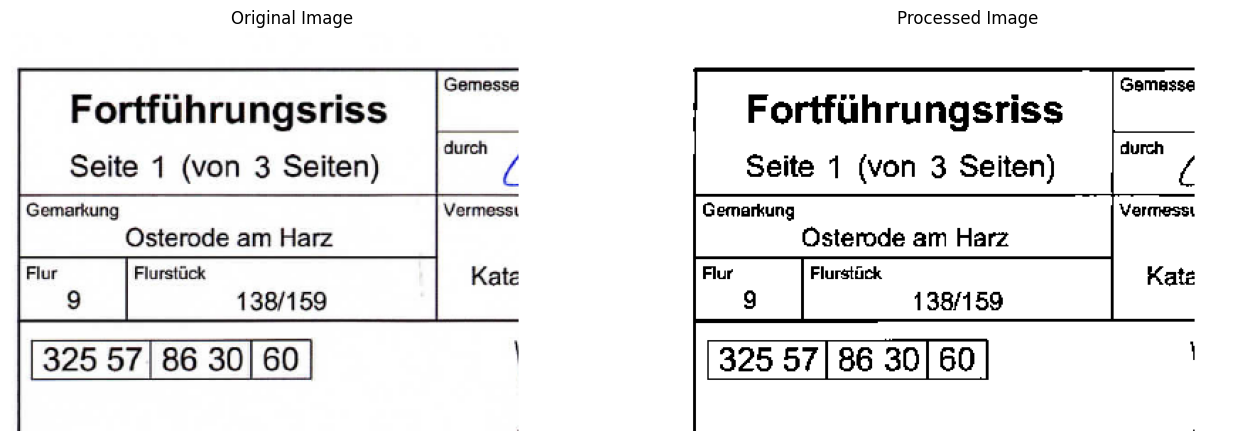

In [93]:
display_images(img_arr, img_preproc, save_path = path_img_input)

In [94]:

data_txt = extract_text(img_arr, confidence_threshold=20, custom_config="-c letter_spacing=35 -c wordrec_max_join_chunks=5")
len(data_txt)
cols = ['text','left','top','width','height','conf']
extracted_text_df = pandas.DataFrame(data_txt, columns=cols)

In [95]:
data_txt

[('Gemesse', 306, 32, 52, 10, 84),
 ('Fortführungsriss', 44, 44, 221, 26, 91),
 ('durch', 306, 77, 30, 9, 95),
 ('Seite', 43, 86, 47, 16, 96),
 ('1', 101, 87, 6, 16, 93),
 ('(von', 122, 86, 39, 21, 96),
 ('3', 173, 87, 10, 16, 96),
 ('Seiten)', 193, 86, 66, 21, 96),
 ('Gemarkung', 12, 120, 64, 13, 93),
 ('Vormesst', 305, 121, 53, 9, 33),
 ('Osterode', 82, 137, 72, 14, 96),
 ('am', 160, 141, 24, 10, 97),
 ('Harz', 191, 138, 36, 13, 95),
 ('Flurstück', 88, 165, 50, 9, 84),
 ('Kate', 325, 165, 33, 14, 96),
 ('138/159', 161, 183, 62, 13, 96),
 ('325', 24, 222, 37, 17, 92),
 ('57|', 69, 222, 24, 17, 49),
 ('86', 108, 222, 23, 17, 49),
 ('\\', 355, 218, 3, 13, 89)]

In [55]:
import pandas as pd
from openpyxl import Workbook

def write_to_excel(extracted_text, output_file="output.xlsx"):
    """Writes extracted text items to an Excel file, one item per cell in a single column.

    Args:
        extracted_text (list): List of tuples containing extracted text information.
        output_file (str): Path to the output Excel file.
    """

    # Extract only the text items (first element of each tuple)
    text_items = [item[0] for item in extracted_text]

    # Split comma-separated items into separate elements
    split_items = [item.split(",") for item in text_items]
    flattened_items = [item for sublist in split_items for item in sublist]

    # Create a DataFrame with the flattened items
    df = pd.DataFrame({"Extracted Text": flattened_items})

    # Create a new Excel workbook and write the DataFrame to it
    wb = Workbook()
    ws = wb.active
    for row in df.itertuples(index=False):
        ws.append(row)

    # Save the workbook
    wb.save(output_file)




In [96]:
output_file= os.path.join(dir_path, f'output_extracted_text_tesseract_{img_pref}.xlsx')
write_to_excel(data_txt, output_file)

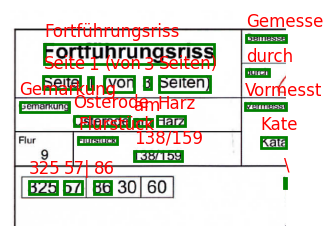

In [97]:
visualize_text_boxes(image = img_arr, dataframe =extracted_text_df , min_conf=0.3, save_path =path_extracted_text)

In [63]:
extracted_text_easyocr = extract_text_easyocr(img_arr, confidence_threshold=5, lang_list=['de'])


In [64]:
extracted_text_easyocr

[('Gemessen am', 503, 153, 132, 20, 0.9992561033277891),
 ('Fortführungsjahr', 959, 148, 151, 31, 0.9997620895620132),
 ('Blatt-Nr .', 1220, 150, 76, 24, 0.9356056288776653),
 ('Fortführungsriss', 90, 163, 361, 61, 0.999959319002469),
 ('07.05.2021', 654, 180, 144, 32, 0.9868842017183389),
 ('2021', 1082, 176, 68, 32, 0.9999977946281433),
 ('G 0992.00(1)', 1229, 178, 171, 36, 0.9993433499857677),
 ('durch', 502, 220, 56, 24, 0.9999976009589855),
 ('Katasteramt', 960, 220, 112, 24, 0.9999735816996862),
 ('Geschäftszeichen', 1220, 220, 160, 24, 0.9797682399580901),
 ('Seite', 92, 234, 85, 39, 0.9999824070167843),
 ('1', 187, 243, 14, 24, 0.9985767901970952),
 ('(von', 215, 237, 72, 40, 0.9999901652336121),
 ('3 Seiten)', 295, 234, 146, 43, 0.9874991074753264),
 ('Le We', 563, 225, 178, 62, 0.37707159885016917),
 ('Uek', 773, 233, 124, 44, 0.3910030997779936),
 ('Osterode am Harz', 970, 246, 236, 32, 0.9130255856293371),
 ('V7-27-2021', 1240, 246, 150, 32, 0.6559794463253368),
 ('Gemarkun

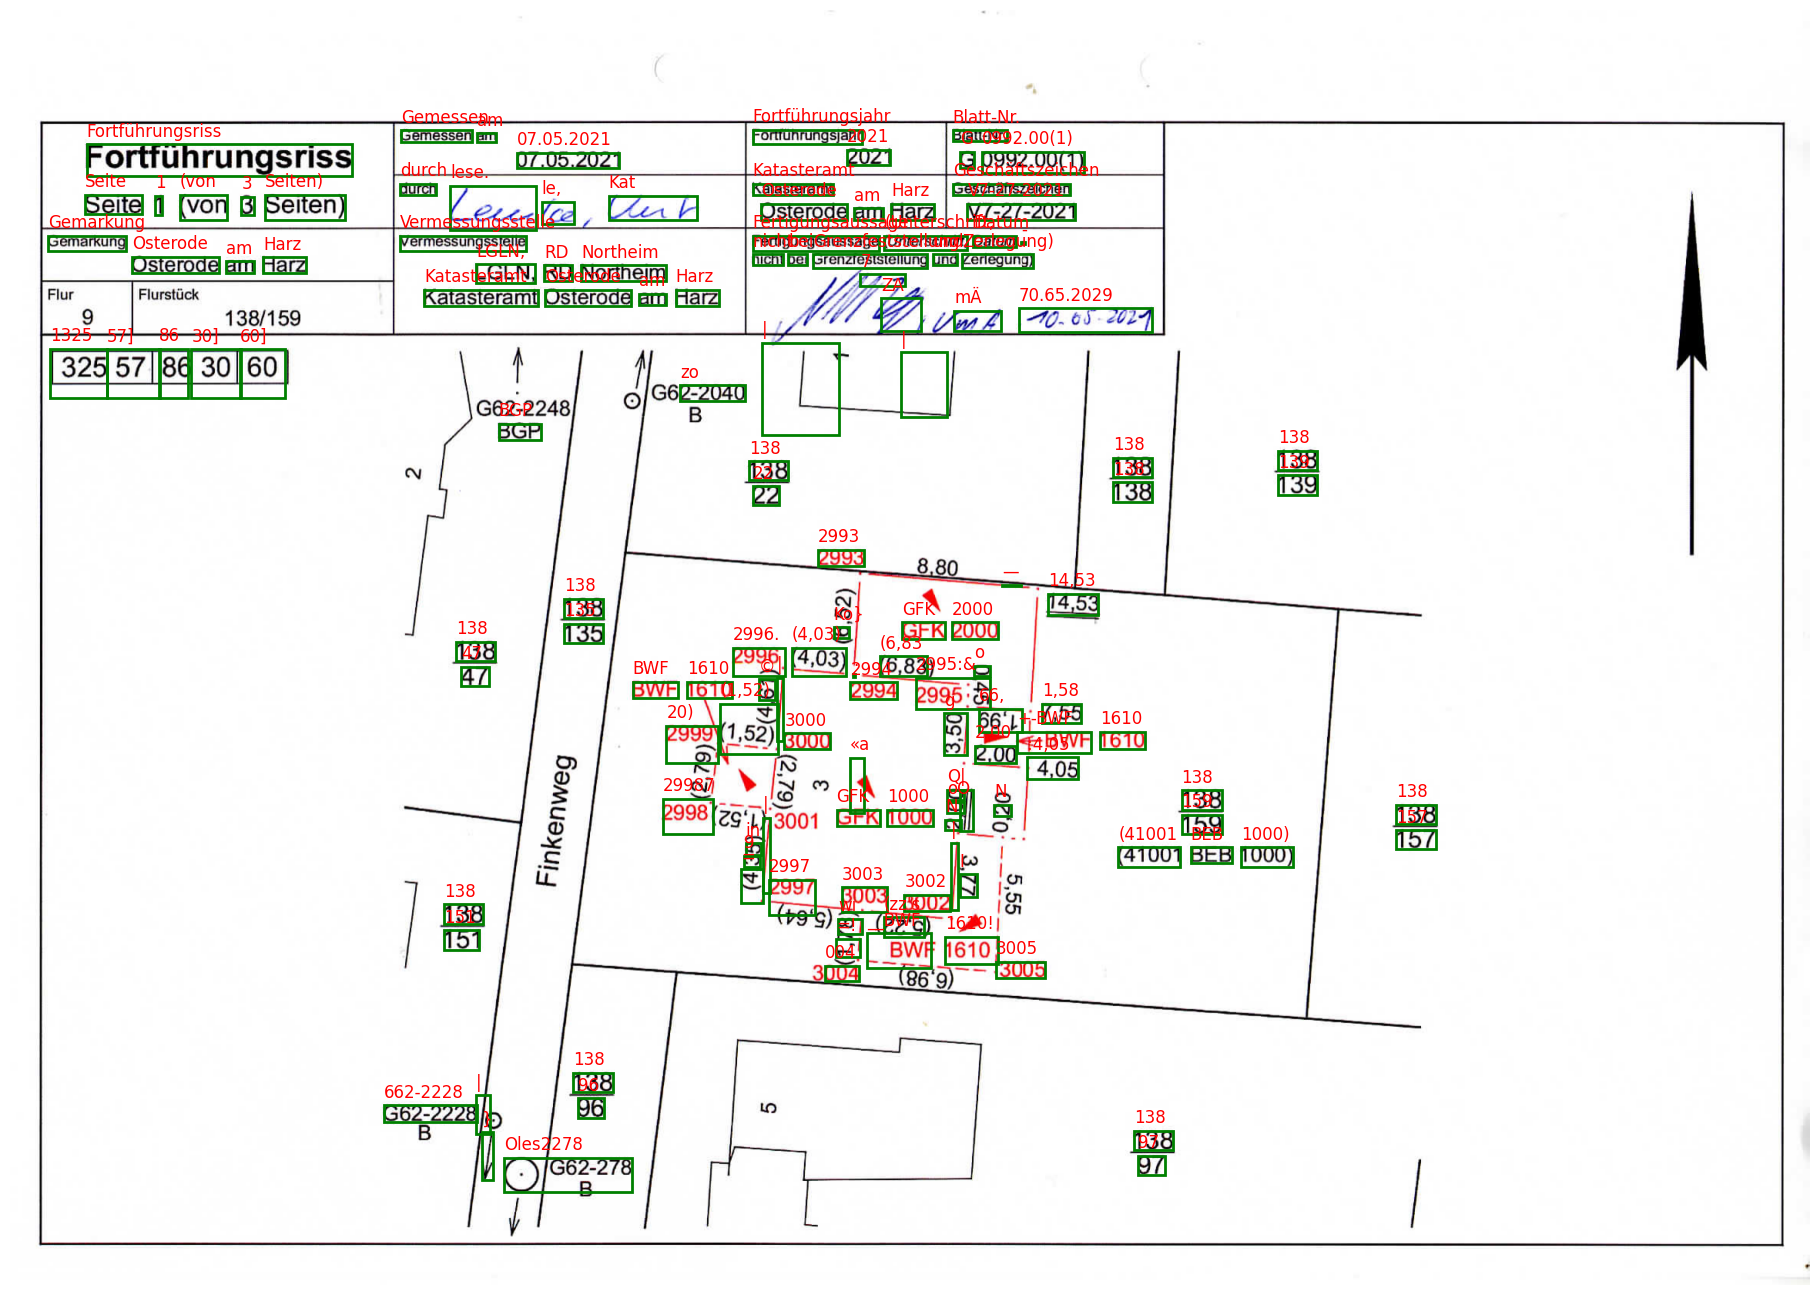

In [65]:
visualize_text_boxes(image = img_arr, dataframe =extracted_text_df , min_conf=0.1, save_path =path_extracted_text)

In [31]:
sens_data_esyocr = find_entities(extracted_text_df, "PER", 0.05)
sens_data_esyocr

ValueError: not enough values to unpack (expected 6, got 4)

In [27]:
sens_data = find_entities(data_txt, "PER", 0.05)
sens_data

[]

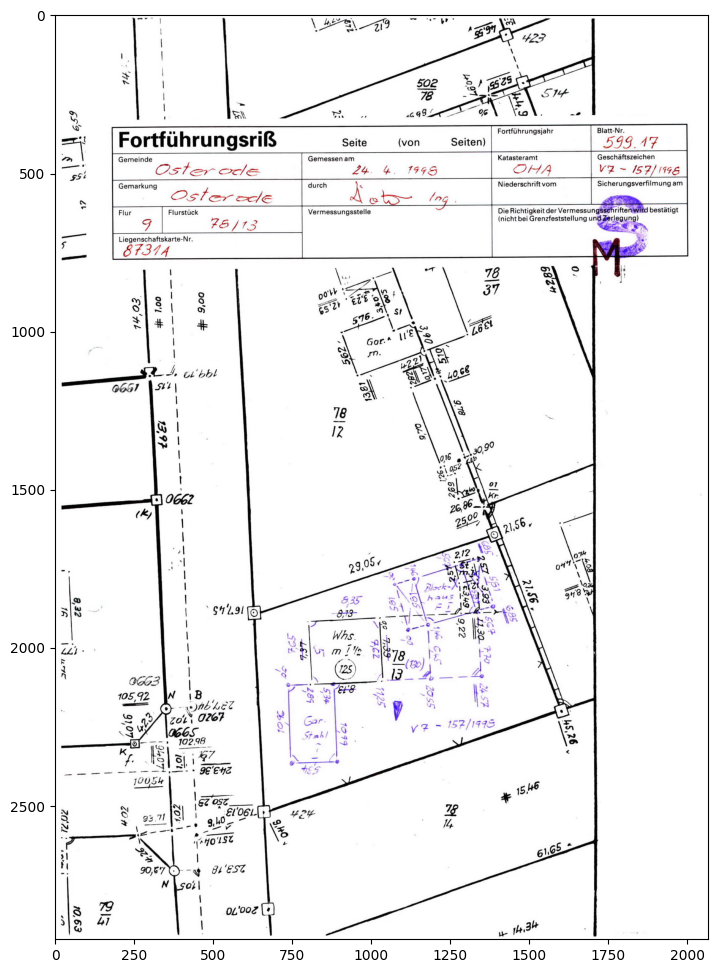

In [ ]:
plot_ner_stanza_results(img_arr, sens_data, figsize=(16, 12), save_path = path_sensitive_text)

In [ ]:


def mask_entities_04(image, entities, output_path, show_image=False, figsize=(10, 10)):
    """
    Masks entities on an image based on their bounding boxes.

    Args:
        image: Numpy array representing the image.
        entities: List of tuples from find_entities (entity text, bbox).
        output_path: Path to save the masked image.
        show_image: If True, displays the image (default: False).
        figsize: Tuple specifying the figure size for display (default: (10, 10)).
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)  # Use original image for plotting rectangles

    for _, entity, bbox, _ in entities:
        left, top, width, height = bbox

        rect = patches.Rectangle((left, top), width, height, linewidth=1, edgecolor='r', facecolor='black')
        ax.add_patch(rect)  # Add rectangle to plot

    # After plotting, save and show the image with masked regions
    fig.savefig(output_path)

    if show_image:
        plt.show()



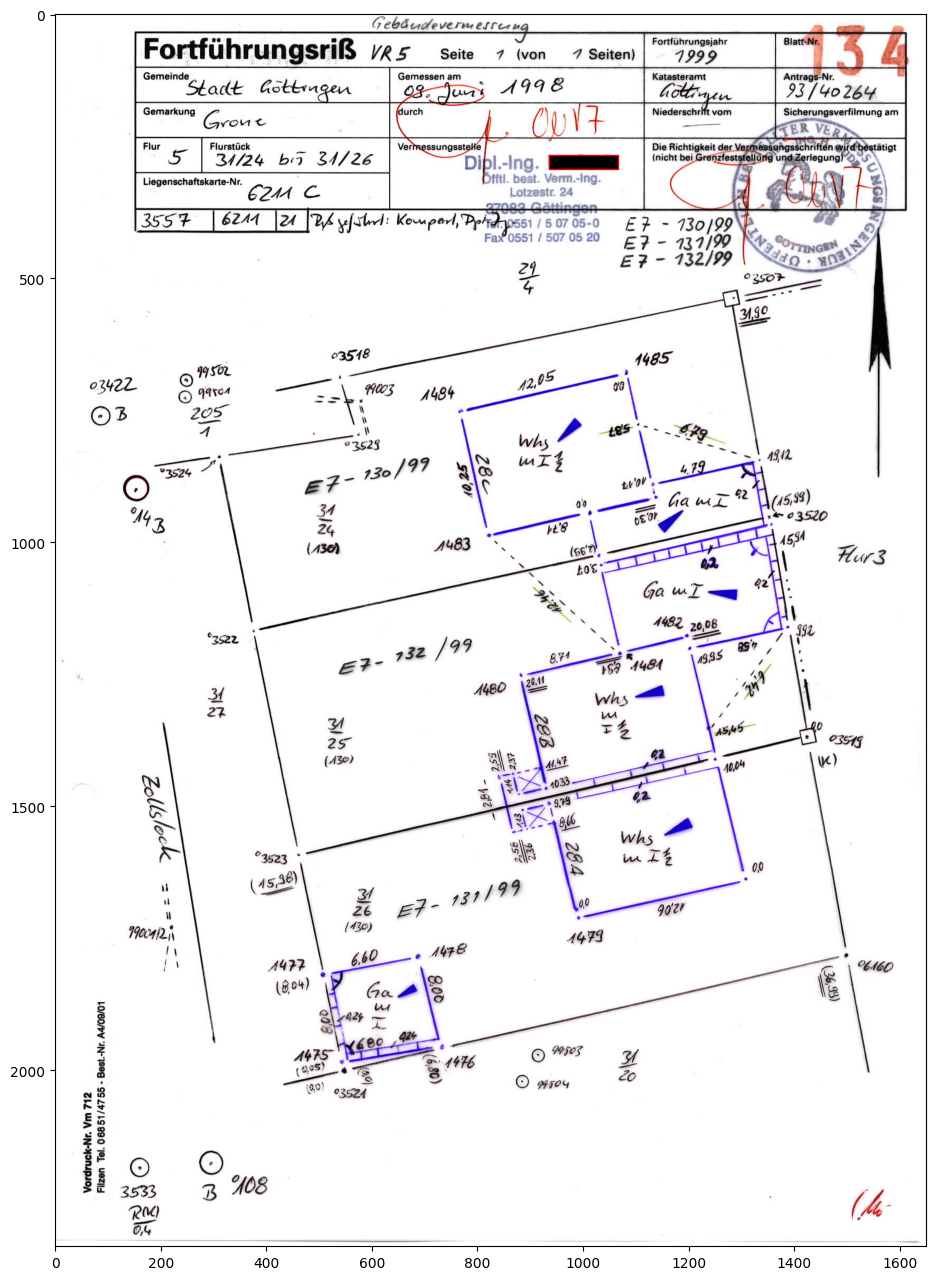

In [ ]:
mask_entities_04(img_arr, sens_data, path_masked_text, show_image=True, figsize=(20, 16))